In [1]:
import os, zipfile
import numpy as np
import matplotlib.pyplot as plt
import tifffile
from glob import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.backend as K

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score

import albumentations as A


In [2]:
DATA_ZIP = "data.zip"
EXTRACT_DIR = "data_extracted"
IMG_DIRNAME = "/content/data_extracted/data/images"
MASK_DIRNAME = "/content/data_extracted/data/labels"
if not os.path.exists(EXTRACT_DIR):
    with zipfile.ZipFile(DATA_ZIP, 'r') as z:
        z.extractall(EXTRACT_DIR)

img_paths = sorted(glob(os.path.join(EXTRACT_DIR, IMG_DIRNAME, "*.tif")))
mask_paths = sorted(glob(os.path.join(EXTRACT_DIR, MASK_DIRNAME, "*.png")))

print(f"Found {len(img_paths)} images and {len(mask_paths)} masks")


Found 306 images and 456 masks


In [3]:
IMG_SIZE = (128, 128)
SELECTED_BANDS = [1, 2, 3, 4, 5, 6, 11]
BAND_NAMES = ["Blue", "Green", "Red", "NIR", "SWIR1", "SWIR2", "WaterProb"]


In [4]:
def load_image(path):
    img = tifffile.imread(path)
    img = img[..., SELECTED_BANDS]
    img = img.astype("float32")
    img /= 255.0
    return img

In [5]:
def load_mask(path):
    mask = plt.imread(path)
    if mask.ndim == 3:
        mask = mask[...,0]

    mask = mask * 255.0
    mask = (mask > 0).astype("float32")

    mask = np.expand_dims(mask, axis=-1)
    return mask

In [6]:
img_basenames = [os.path.splitext(os.path.basename(p))[0] for p in img_paths]
mask_basenames = [os.path.splitext(os.path.basename(p))[0] for p in mask_paths]

common = set(img_basenames) & set(mask_basenames)
print(f"Images: {len(img_paths)}, Masks: {len(mask_paths)}, Common: {len(common)}")

img_paths_filtered = [p for p in img_paths if os.path.splitext(os.path.basename(p))[0] in common]
mask_paths_filtered = [p for p in mask_paths if os.path.splitext(os.path.basename(p))[0] in common]

img_paths_filtered = sorted(img_paths_filtered)
mask_paths_filtered = sorted(mask_paths_filtered)
print(f"Filtered Images: {len(img_paths_filtered)}, Filtered Masks: {len(mask_paths_filtered)}")



Images: 306, Masks: 456, Common: 306
Filtered Images: 306, Filtered Masks: 306


In [7]:
def normalize_band(band):
    band_min, band_max = band.min(), band.max()
    if band_max > band_min:
        return (band - band_min) / (band_max - band_min)
    else:
        return np.zeros_like(band)

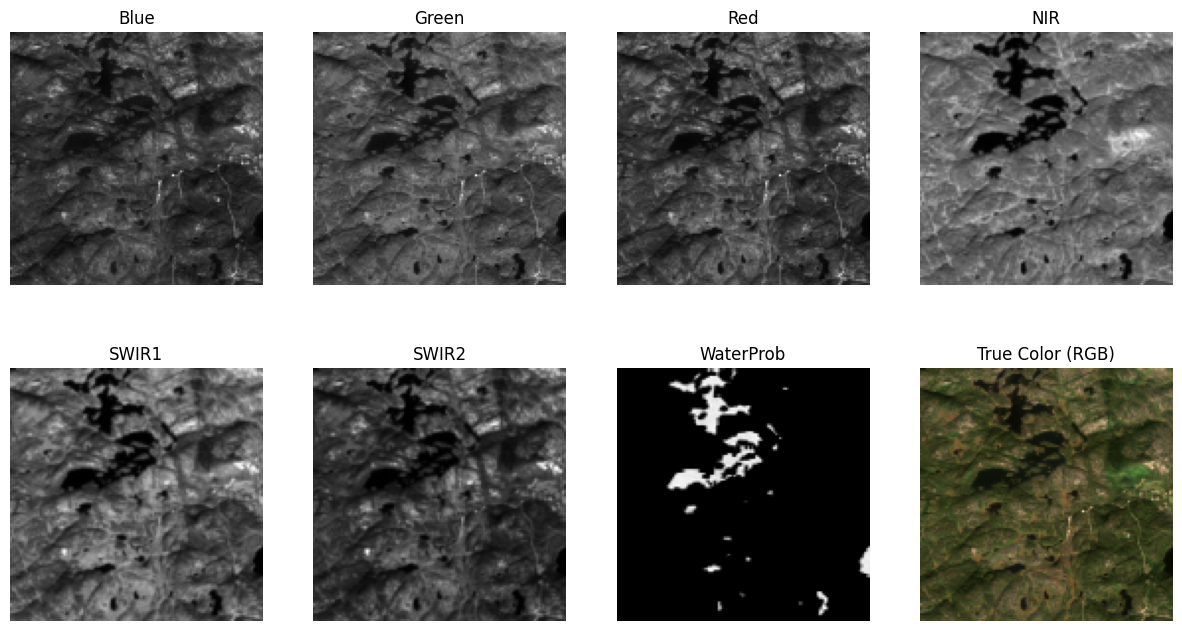

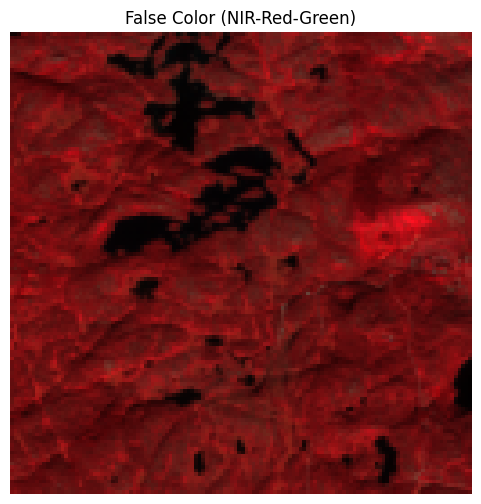

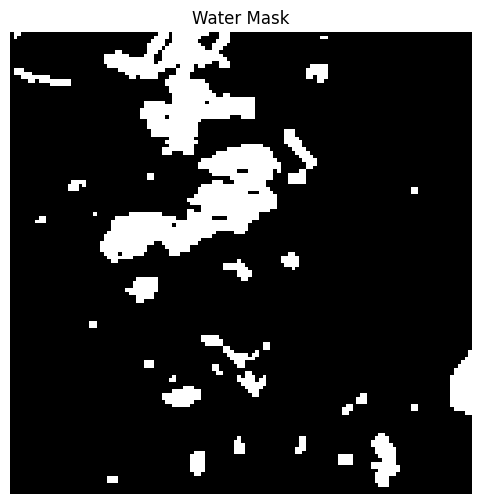

In [8]:
def visualize_bands(img_path, mask_path):
    img = tifffile.imread(img_path)
    img = img[..., SELECTED_BANDS]
    mask = load_mask(mask_path).squeeze()

    fig, axes = plt.subplots(2, 4, figsize=(15,8))
    for i in range(len(SELECTED_BANDS)):
        ax = axes.flat[i]
        ax.imshow(img[..., i], cmap="gray")
        ax.set_title(BAND_NAMES[i])
        ax.axis("off")

    rgb = np.stack([
        img[..., BAND_NAMES.index("Red")],
        img[..., BAND_NAMES.index("Green")],
        img[..., BAND_NAMES.index("Blue")]
    ], axis=-1)
    rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min())
    axes.flat[-1].imshow(rgb)
    axes.flat[-1].set_title("True Color (RGB)")
    axes.flat[-1].axis("off")

    plt.show()

    false_rgb = np.stack([
        img[..., BAND_NAMES.index("NIR")],
        img[..., BAND_NAMES.index("Red")],
        img[..., BAND_NAMES.index("Green")]
    ], axis=-1)
    false_rgb = (false_rgb - false_rgb.min()) / (false_rgb.max() - false_rgb.min())

    plt.figure(figsize=(6,6))
    plt.imshow(false_rgb)
    plt.title("False Color (NIR-Red-Green)")
    plt.axis("off")
    plt.show()

    # Mask
    plt.figure(figsize=(6,6))
    plt.imshow(mask, cmap="gray")
    plt.title("Water Mask")
    plt.axis("off")
    plt.show()

visualize_bands(img_paths[0], mask_paths[0])


In [9]:
def preview_dataset1(images, masks, n=5, bands=None):
    plt.figure(figsize=(12, 6))
    for i in range(n):
        img = load_image(images[i])
        mask = load_mask(masks[i])


        if bands is not None:
            if all(b < img.shape[-1] for b in bands):
                img_to_show = img[..., bands]
            else:
                raise ValueError(f"Some selected bands {bands} exceed image channels {img.shape[-1]}")
        else:
            if img.shape[-1] >= 3:
                img_to_show = img[..., :3]
            else:
                img_to_show = img.squeeze()


        if img_to_show.ndim == 3:
            img_to_show = np.stack(
                [normalize_band(img_to_show[..., j]) for j in range(img_to_show.shape[-1])],
                axis=-1
            )
        else:
            img_to_show = normalize_band(img_to_show)


        plt.subplot(2, n, i+1)
        plt.imshow(img_to_show, cmap=None if img_to_show.ndim == 3 else "gray")
        plt.title(f"Image {i}")
        plt.axis("off")


        plt.subplot(2, n, i+1+n)
        plt.imshow(mask.squeeze(), cmap="gray")
        plt.title(f"Mask {i}")
        plt.axis("off")

    plt.show()


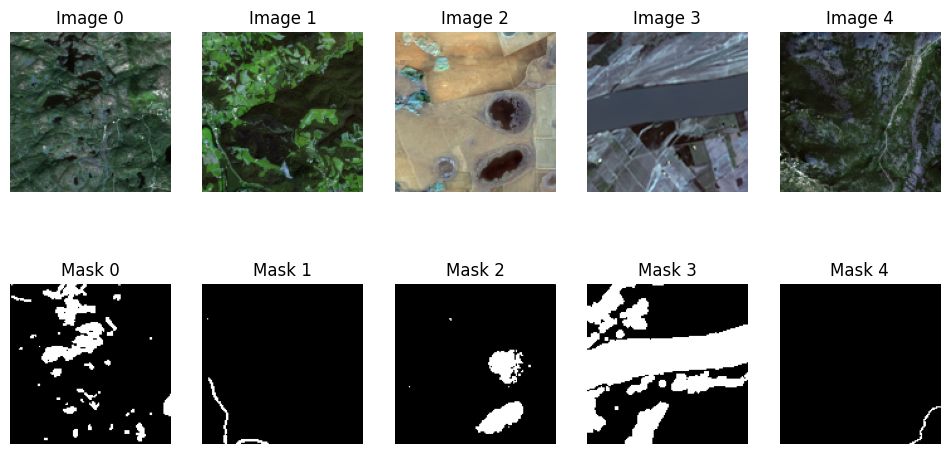

In [10]:
preview_dataset1(img_paths_filtered, mask_paths_filtered, n=5)

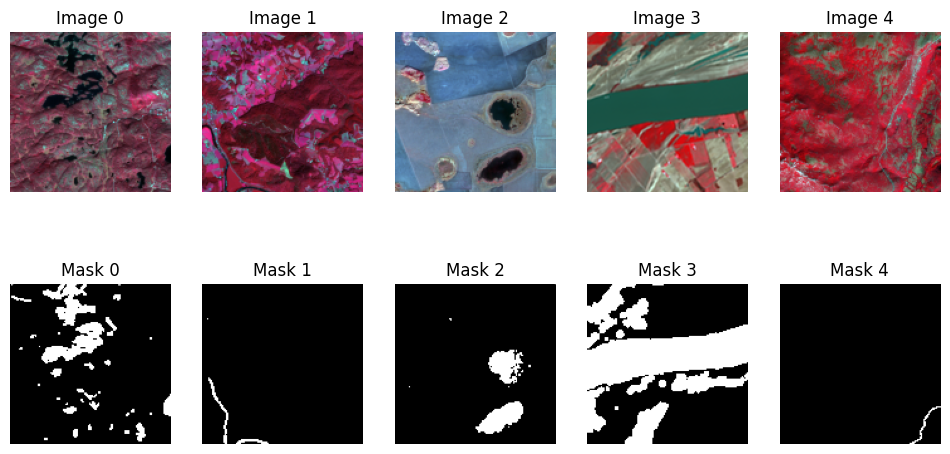

In [11]:
preview_dataset1(img_paths_filtered, mask_paths_filtered, n=5, bands=[3,2,1])

In [12]:
def preview_dataset2(images, masks, n=3, bands=None, mode="rgb"):
    for idx in range(n):
        img = load_image(images[idx])
        mask = load_mask(masks[idx])

        if mode == "rgb":
            if bands is None:
                bands = [2, 1, 0]
            img_to_show = img[..., bands]


            img_to_show = np.stack([normalize_band(img_to_show[..., i]) for i in range(img_to_show.shape[-1])], axis=-1)

            plt.figure(figsize=(6, 6))
            plt.imshow(img_to_show)
            plt.title(f"Image {idx} (Bands {bands})")
            plt.axis("off")
            plt.show()

        elif mode == "bands":
            num_bands = img.shape[-1]
            plt.figure(figsize=(15, 3))
            for b in range(num_bands):
                plt.subplot(1, num_bands, b+1)
                plt.imshow(normalize_band(img[..., b]), cmap="gray")
                title = BAND_NAMES[b] if b < len(BAND_NAMES) else f"Band {b}"
                plt.title(title)
                plt.axis("off")
            plt.suptitle(f"Image {idx} - All Bands", fontsize=14)
            plt.show()

        elif mode == "compare":
            if bands is None:
                bands = [2, 1, 0]
            img_to_show = img[..., bands]


            img_to_show = np.stack([normalize_band(img_to_show[..., i]) for i in range(img_to_show.shape[-1])], axis=-1)

            plt.figure(figsize=(10, 5))
            plt.subplot(1, 2, 1)
            plt.imshow(img_to_show)
            plt.title(f"Image {idx}")
            plt.axis("off")

            plt.subplot(1, 2, 2)
            plt.imshow(mask.squeeze(), cmap="gray")
            plt.title(f"Mask {idx}")
            plt.axis("off")
            plt.show()


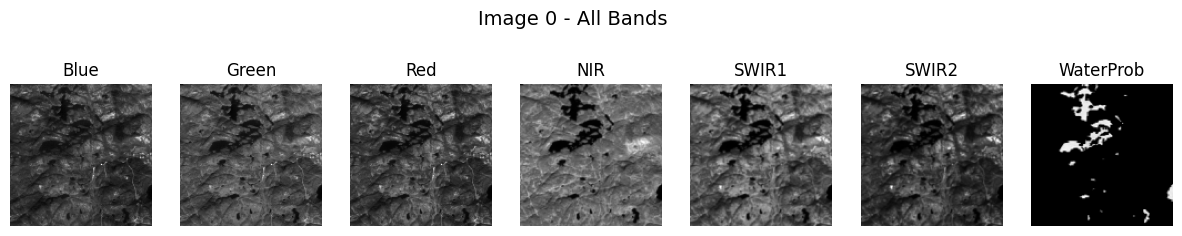

In [13]:
preview_dataset2(img_paths_filtered, mask_paths_filtered, n=1, mode="bands")

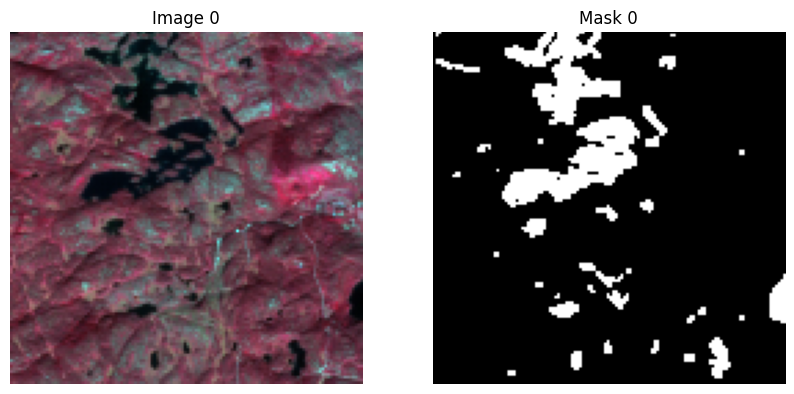

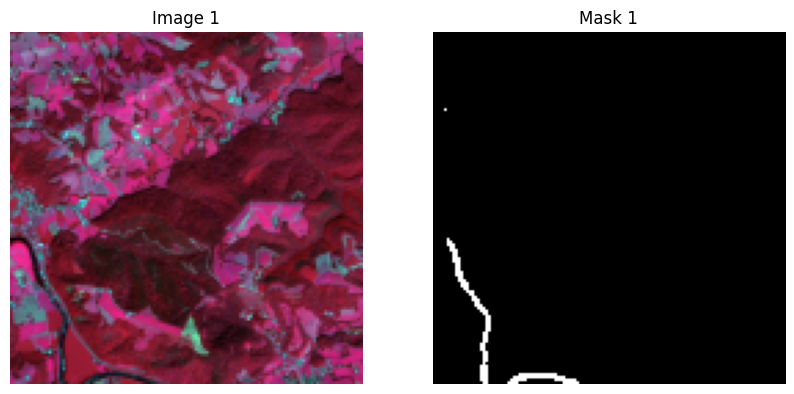

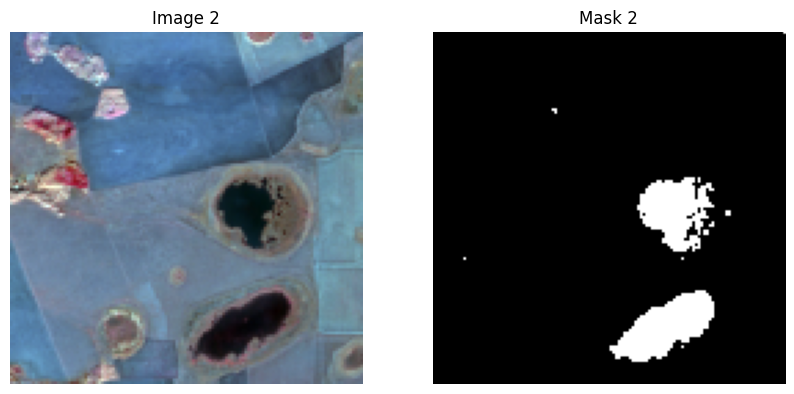

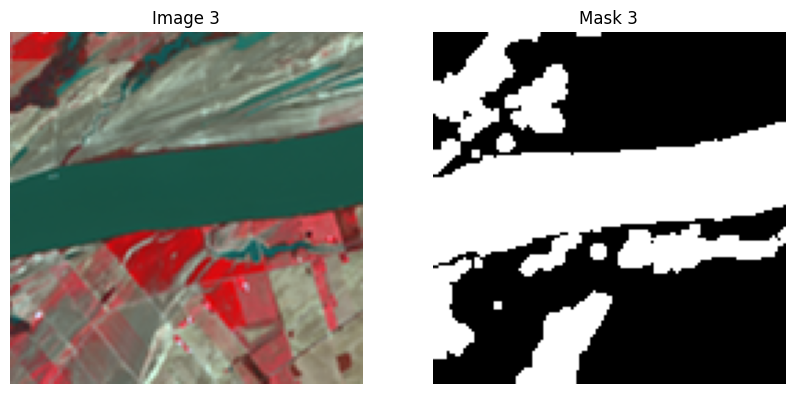

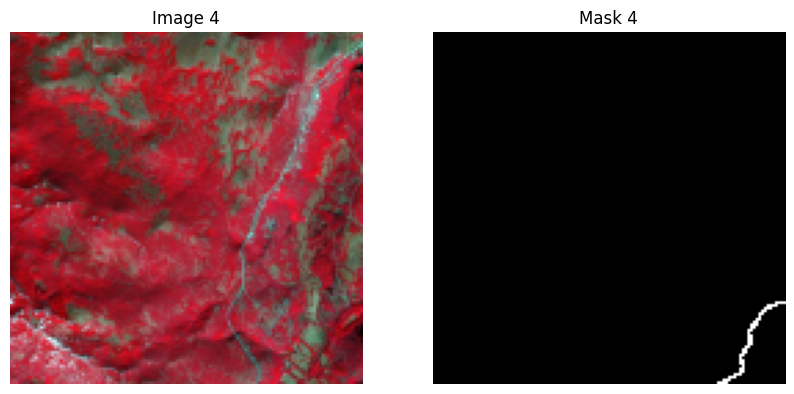

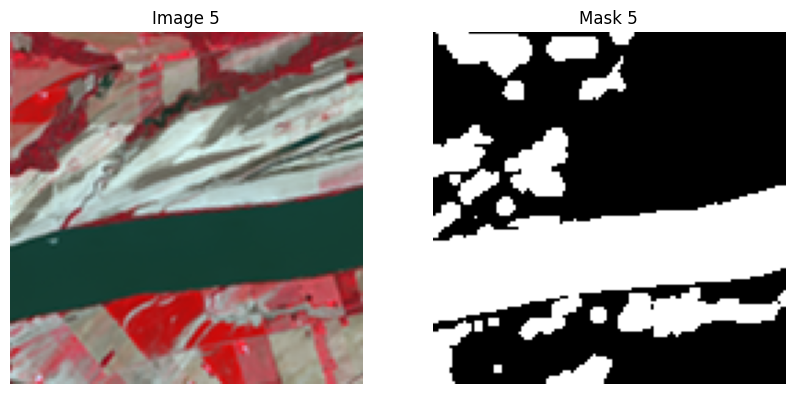

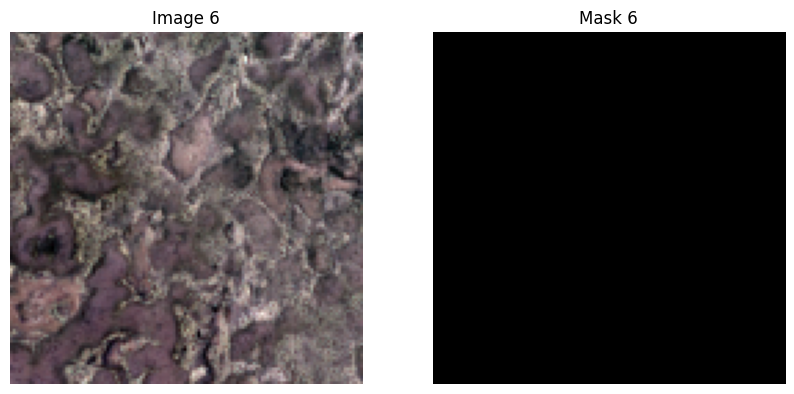

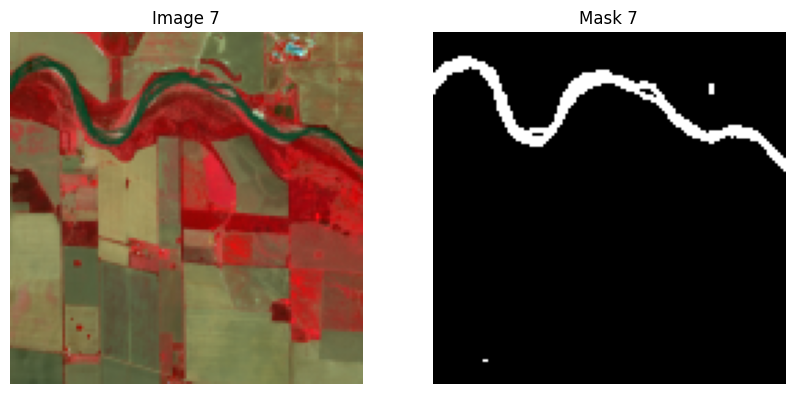

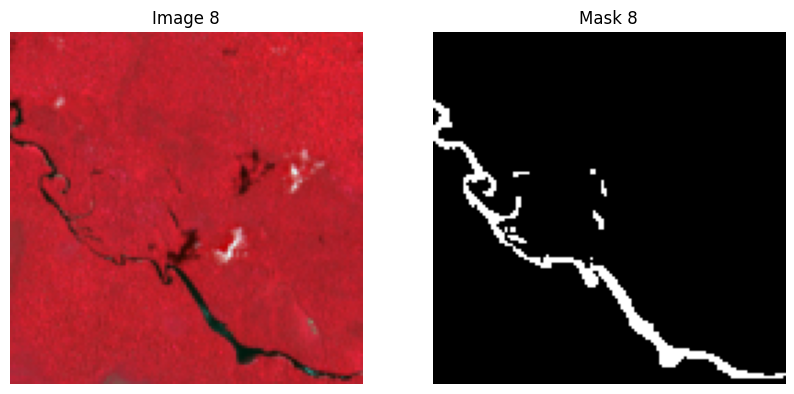

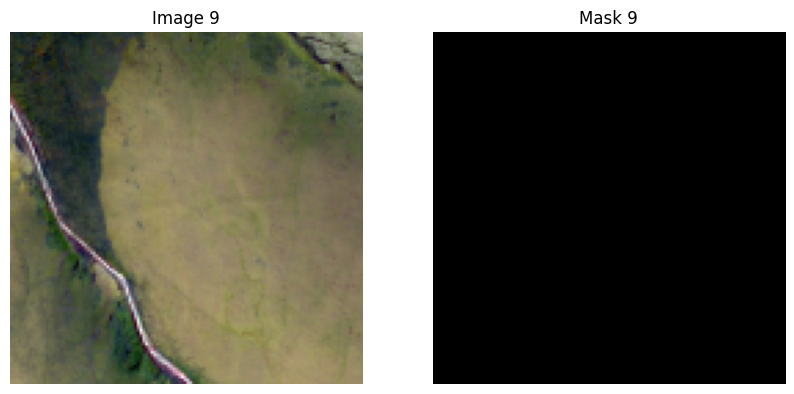

In [14]:
preview_dataset2(img_paths_filtered, mask_paths_filtered, n=10, bands=[3,2,1], mode="compare")

In [15]:
def analyze_masks(masks):

    water_pixels = []

    for mask in masks:

        if isinstance(mask, str):
            mask_arr = load_mask(mask).squeeze()
        else:
            mask_arr = mask.squeeze()

        water_pixels.append(np.sum(mask_arr))

    water_pixels = np.array(water_pixels)


    print(f"Total masks: {len(masks)}")
    print(f"Images with NO water: {(water_pixels==0).sum()} / {len(masks)}")
    print(f"Min water pixels: {water_pixels.min()}")
    print(f"Max water pixels: {water_pixels.max()}")
    print(f"Mean water pixels: {water_pixels.mean():.2f}")


    plt.figure(figsize=(8,5))
    plt.hist(water_pixels, bins=30, color="blue", alpha=0.7)
    plt.xlabel("Number of water pixels per mask")
    plt.ylabel("Count")
    plt.title("Distribution of water pixels across masks")
    plt.show()




🔹masks:
Total masks: 306
Images with NO water: 45 / 306
Min water pixels: 0.0
Max water pixels: 16384.0
Mean water pixels: 4255.79


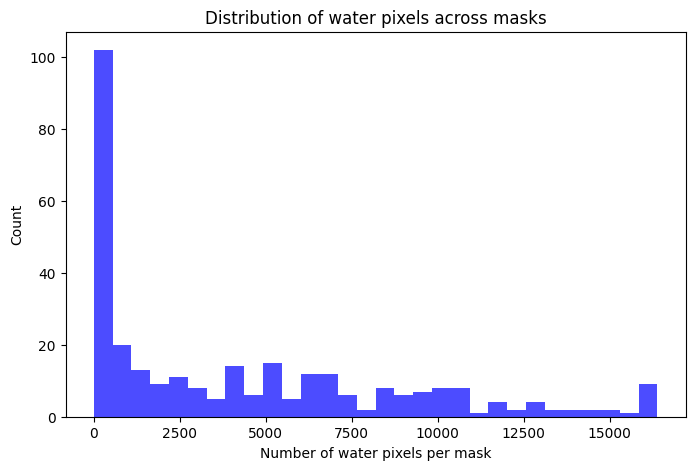

In [16]:
print("🔹masks:")
analyze_masks(mask_paths_filtered)

In [17]:
# mask_raw = plt.imread(mask_paths[0])
# plt.imshow(mask_raw)
# plt.title("Raw Mask")
# plt.show()
# print("Mask unique values:", np.unique(mask_raw))


In [18]:
X = np.array([load_image(p) for p in img_paths_filtered])
y = np.array([load_mask(p) for p in mask_paths_filtered])

print("Images shape:", X.shape)
print("Masks shape:", y.shape)

Images shape: (306, 128, 128, 7)
Masks shape: (306, 128, 128, 1)


In [19]:
train_imgs, test_imgs, train_masks, test_masks = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42
)
print(f"Train: {len(train_imgs)} images, {len(train_masks)} masks")
print(f"Test:  {len(test_imgs)} images, {len(test_masks)} masks")

Train: 214 images, 214 masks
Test:  92 images, 92 masks


In [20]:
print("train imgs:", train_imgs.shape)
print("train masks:",train_masks.shape)
print("test imgs:", test_imgs.shape)
print("test masks:",  test_masks.shape)

train imgs: (214, 128, 128, 7)
train masks: (214, 128, 128, 1)
test imgs: (92, 128, 128, 7)
test masks: (92, 128, 128, 1)


In [21]:
def unet_model(input_shape=(128,128,7)):
    inputs = keras.Input(shape=input_shape)

    c1 = layers.Conv2D(8, 3, padding="same", activation="relu")(inputs)
    c1 = layers.Conv2D(8, 3, padding="same", activation="relu")(c1)
    p1 = layers.MaxPooling2D((2,2))(c1)

    c2 = layers.Conv2D(16, 3, padding="same", activation="relu")(p1)
    c2 = layers.Conv2D(16, 3, padding="same", activation="relu")(c2)
    p2 = layers.MaxPooling2D((2,2))(c2)

    c3 = layers.Conv2D(32, 3, padding="same", activation="relu")(p2)
    c3 = layers.Conv2D(32, 3, padding="same", activation="relu")(c3)
    p3 = layers.MaxPooling2D((2,2))(c3)

    bn = layers.Conv2D(64, 3, padding="same", activation="relu")(p3)
    bn = layers.Conv2D(64, 3, padding="same", activation="relu")(bn)

    d2 = layers.Conv2DTranspose(32, (2,2), strides=2, padding="same")(bn)
    d2 = layers.Concatenate()([d2, c3])
    d2 = layers.Conv2D(32, 3, padding="same", activation="relu")(d2)
    d2 = layers.Conv2D(32, 3, padding="same", activation="relu")(d2)

    d3 = layers.Conv2DTranspose(16, (2,2), strides=2, padding="same")(d2)
    d3 = layers.Concatenate()([d3, c2])
    d3 = layers.Conv2D(16, 3, padding="same", activation="relu")(d3)
    d3 = layers.Conv2D(16, 3, padding="same", activation="relu")(d3)

    d4 = layers.Conv2DTranspose(8, (2,2), strides=2, padding="same")(d3)
    d4 = layers.Concatenate()([d4, c1])
    d4 = layers.Conv2D(8, 3, padding="same", activation="relu")(d4)
    d4 = layers.Conv2D(8, 3, padding="same", activation="relu")(d4)

    outputs = layers.Conv2D(1, (1,1), activation="sigmoid")(d4)

    return keras.Model(inputs, outputs)


model = unet_model(input_shape=(128,128,7))
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 7)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        512 │ input_layer[0][0] │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │        584 │ conv2d[0][0]      │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64, 8) │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │      1,168 │ max_pooling2d[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │      2,320 │ conv2d_2[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │      4,640 │ max_pooling2d_1[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │      9,248 │ conv2d_4[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │     18,496 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │     36,928 │ conv2d_6[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 32, 32,    │      8,224 │ conv2d_7[0][0]    │
│ (Conv2DTranspose)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 64)               │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 32,    │     18,464 │ concatenate[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 32, 32,    │      9,248 │ conv2d_8[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 64, 64,    │      2,064 │ conv2d_9[0][0]  

 Total params: 121,113 (473.10 KB)

 Trainable params: 121,113 (473.10 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "best_unet_model.keras",
    monitor="val_accuracy",
    mode="max",
    save_best_only=True,
    verbose=1
)

In [23]:
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])


In [24]:
history = model.fit(
    train_imgs, train_masks,
    validation_data=(test_imgs, test_masks),
    epochs=100,
    batch_size=8,
    callbacks=checkpoint
)


Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.8169 - loss: 0.4180
Epoch 1: val_accuracy improved from -inf to 0.88969, saving model to best_unet_model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 19s 299ms/step - accuracy: 0.8187 - loss: 0.4170 - val_accuracy: 0.8897 - val_loss: 0.3751
Epoch 2/100
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8911 - loss: 0.3123
Epoch 2: val_accuracy improved from 0.88969 to 0.89274, saving model to best_unet_model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8910 - loss: 0.3138 - val_accuracy: 0.8927 - val_loss: 0.3229
Epoch 3/100
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8951 - loss: 0.3044
Epoch 3: val_accuracy improved from 0.89274 to 0.89592, saving model to best_unet_model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8948 - loss: 0.3059 - val_accuracy: 0.8959 - val_loss: 0.3140
Epoch 4/100
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9021 - loss: 0.3096
Epoch 4: val_accuracy impr

In [25]:
loss, acc = model.evaluate(test_imgs,test_masks)
print(f"test loss: {loss:.4f} ,test acc:  {acc:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 694ms/step - accuracy: 0.9429 - loss: 0.2474
test loss: 0.2678 ,test acc:  0.9402


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 320ms/step
Confusion Matrix:
 [[1136326   29021]
 [  61173  280808]]


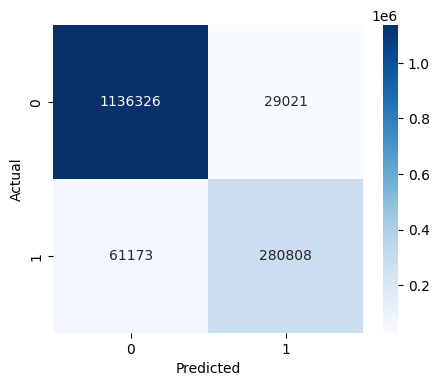

Classification Report:
               precision    recall  f1-score   support

  Background       0.95      0.98      0.96   1165347
  Foreground       0.91      0.82      0.86    341981

    accuracy                           0.94   1507328
   macro avg       0.93      0.90      0.91   1507328
weighted avg       0.94      0.94      0.94   1507328

Overall IOU: 0.7568907984323535


In [26]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

preds = model.predict(test_imgs)
preds_bin = (preds > 0.5).astype(np.uint8)

y_true = test_masks.flatten()
y_pred = preds_bin.flatten()

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

report = classification_report(y_true, y_pred, target_names=["Background", "Foreground"])
print("Classification Report:\n", report)

intersection = np.logical_and(y_true, y_pred).sum()
union = np.logical_or(y_true, y_pred).sum()
iou = intersection / union
print("Overall IOU:", iou)
